In [31]:
import mplfinance as mpf
import pandas as pd
from pathlib import Path
import numpy as np
import datetime

In [32]:
# Get BTC OHLCV dataframe
df = pd.read_csv(Path("BTC-USD-20201005-20211005.csv"), index_col="Date", parse_dates=True, infer_datetime_format=True)
df.drop(['Adj Close'], axis=1, inplace=True)
display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-05,10688.034180,10804.000977,10646.443359,10804.000977,1.938519e+10
2020-10-06,10799.778320,10803.456055,10565.197266,10621.664063,2.226496e+10
2020-10-07,10619.803711,10687.268555,10591.963867,10679.136719,1.763439e+10
2020-10-08,10677.625000,10939.799805,10569.823242,10923.627930,2.196212e+10
2020-10-09,NaN,NaN,NaN,NaN,NaN


,Open,High,Low,Close,Volume
Date,,,,,
2021-10-01,43816.742188,48436.011719,43320.023438,48116.941406,4.285064e+10
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,3.061435e+10
2021-10-03,47680.027344,49130.691406,47157.289063,48199.953125,2.663812e+10
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,3.338317e+10
2021-10-05,49164.750000,51282.441406,49119.136719,51267.457031,3.463356e+10


In [33]:
# Slice of double bottom
intra = df.loc['01-16-2021':'02-17-2021']
intra.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-16,36821.648438,37864.367188,35633.554688,36178.140625,5.770619e+10
2021-01-17,36163.648438,36722.351563,34069.320313,35791.277344,5.235985e+10
2021-01-18,35792.238281,37299.285156,34883.843750,36630.074219,4.951170e+10
2021-01-19,36642.234375,37755.890625,36069.804688,36069.804688,5.724420e+10
2021-01-20,36050.113281,36378.328125,33570.476563,35547.750000,6.683457e+10


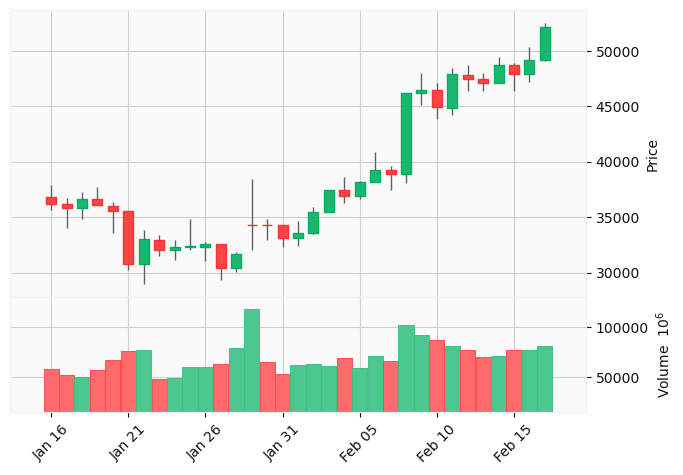

In [34]:
mpf.plot(intra, type="candle", style="yahoo", volume=True)

In [35]:
intra.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33 entries, 2021-01-16 to 2021-02-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    33 non-null     float64
 1   High    33 non-null     float64
 2   Low     33 non-null     float64
 3   Close   33 non-null     float64
 4   Volume  33 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [36]:
# Check if there is a previous bar
def update_cert(cert, index, df):
    # Create certifying candle
    # count number of null values to see if is first row
    null_count = 0
    for value in cert.values():
        if value == None:
            null_count += 1
    
    # update prev dictionary if all null values
    # if first row it will update with those values
    if null_count == 5:
        cert['t'] = index
        cert['o'] = float(df.loc[index]['Open'])
        cert['c'] = float(df.loc[index]['Close'])
        cert['h'] = float(df.loc[index]['High'])
        cert['l'] = float(df.loc[index]['Low'])
        
        # return the certying candle dictionary
        return cert
    
    # update prev with new prev values (new prev is old curr)
    else:
        if index + datetime.timedelta(days=1):
            cert['t'] = (index)
            cert['o'] = float(df.loc[index]['Open'])
            cert['c'] = float(df.loc[index]['Close'])
            cert['h'] = float(df.loc[index]['High'])
            cert['l'] = float(df.loc[index]['Low'])
        
            # return the certying candle dictionary
            return cert
        
def update_curr(curr, index, df):
    # Create current dictionary of current candle
    idx = df.index  
    
    # format datetime index
    dt_object = (index - datetime.timedelta(days=1)).to_datetime64()
    
    if sum(df.index == dt_object) > 0:
        index -= datetime.timedelta(days=1)
        curr['t'] = (index)
        curr['o'] = float(df.loc[index]['Open'])
        curr['c'] = float(df.loc[index]['Close'])
        curr['h'] = float(df.loc[index]['High'])
        curr['l'] = float(df.loc[index]['Low'])
        
        # return the current candle dictionary
        return curr
    else:
        pass
        
def update_prev(prev, index, df):
    # Create the previous candle
    idx = df.index
    

    dt_object = (index - datetime.timedelta(days=2)).to_datetime64()

    if sum(df.index == dt_object) > 0:
        index -= datetime.timedelta(days=2)
        prev['t'] = (index)
        prev['o'] = float(df.loc[index]['Open'])
        prev['c'] = float(df.loc[index]['Close'])
        prev['h'] = float(df.loc[index]['High'])
        prev['l'] = float(df.loc[index]['Low'])
        
        # return the previous candle dictionary
        return prev
    else:
        pass

In [37]:
def find_max(cert_candle, curr_candle, prev_candle):
    # get local max
    max_dict = {}
    if curr_candle and prev_candle:       
        if (curr_candle['c'] > cert_candle['c']) & (curr_candle['c'] > prev_candle['c']):
            max_dict = curr_candle
            return max_dict
        else:
            return None
        
def find_min(cert_candle, curr_candle, prev_candle):   
    # get local min
    min_dict = {}
    if curr_candle and prev_candle:
        if (curr_candle['c'] < cert_candle['c']) & (curr_candle['c'] < prev_candle['c']):
            min_dict = curr_candle
            return min_dict
        else:
            return None

In [45]:
def create_dataframe(df):
    """
    Create DataFrame with local minimums and maximums to create signals for double bottom creation
    Accepts DataFrames with columns formatted as 'Open', 'Close', 'High', 'Low'.
    More columns can be added.
    """
    
    # # store previous candle
    prev = {
        't' : None,
        'o' : None,
        'c' : None,
        'h' : None,
        'l' : None   
    }

    # store current candle
    curr = {
        't' : None,
        'o' : None,
        'c' : None,
        'h' : None,
        'l' : None 
    }

    # store certifying candle (certifies if the max/min is created)
    cert = {
        't' : None,
        'o' : None,
        'c' : None,
        'h' : None,
        'l' : None 
    }

    # Init lists for max and min events
    max_ = []
    min_ = []

    # Iterrate through dataframes indexes
    for index in df.index:
        cert_candle = update_cert(cert, index, df)
        curr_candle = update_curr(curr, index, df)
        prev_candle = update_prev(prev, index, df)

        # pont f arbitrary - 5 periods out
        # when finished will have 6 values
        mx = find_max(cert_candle, curr_candle, prev_candle)
        mn = find_min(cert_candle, curr_candle, prev_candle)

        # max stores close and high
        # min stores close and low
        if mx == None:
            max_.append(0)
        else:
            max_.append(1)

        if mn == None:
            min_.append(0)      
        else:
            min_.append(1)

    # Adding min/max events to original dataframe then creating a copy with columns for double bottom events
    max_min_df = pd.DataFrame({'Max': max_, 'Min': min_})
    max_min_df = max_min_df[['Max', 'Min']].shift(-1)
    max_min_df['Date'] = df.index
    max_min_df.set_index('Date', inplace=True)
    df_features = pd.concat([df, max_min_df], axis=1)
    df_features[['A', 'B', 'C', 'D', 'E', 'F', 'DB']] = 0.0
    
    return df_features

In [46]:
display(create_dataframe(intra).head())
new_df = create_dataframe(intra)

,Open,High,Low,Close,Volume,Max,Min,A,B,C,D,E,F,DB
Date,,,,,,,,,,,,,,
2021-01-16,36821.648438,37864.367188,35633.554688,36178.140625,5.770619e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-17,36163.648438,36722.351563,34069.320313,35791.277344,5.235985e+10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-18,35792.238281,37299.285156,34883.843750,36630.074219,4.951170e+10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-19,36642.234375,37755.890625,36069.804688,36069.804688,5.724420e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-20,36050.113281,36378.328125,33570.476563,35547.750000,6.683457e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# event_list_shannon = []
# def create_list_of_event_points_to_add_to_event_dictionar(date_range_dataframe):
#     for i in date_range_dataframe check if this date's prices' make up local max
#         if yes, store to list labeled event %(+1) = ['a']
#         (assign position of a list to a variable)
#         check event1_list; if [0] is not null then check if this date's prices' make up a local min and assign value b
#         check event1_list; if [1] is not null then check if this date's prices' make up a local max and assign value c; c should be lower than a but higher than b; if conditions are not met, clear event list and start new list iteration on next date
#         check event1_list; if [2] is not null then check if this date's prices' make up a local min and assign value d; if this is min then continue to [check for b conditions]  if local min close is in range of b (between b close and b low) then local min event point d or if local min d low is in range of b close and b low then local min is event point d, elif close d is below b low then delete list and start next date     
#         check event1_list; if [3] is not null then check if this date's prices'are higher than event point c and assign value e
#         check event1_list; if [4] is not null then find price 5 days after point e and label this +5 day price point f
#         check event1_list; if [5] is not null then find price 5 days before point a and label this as the"lead up" event point

In [71]:
def get_events(new_df):
    """Returns dataframe with binary encoded events"""
    
    events_list = [None, None, None, None, None]
    search_c = {}
    
    buy = None
    sell = None
    
    for index in new_df.index:
        # Start search for A if A is none
        if events_list[0] == None:
            if new_df.loc[index]['Max'] == 1:
                events_list[0] = index
                new_df.loc[index]['A'] = 1.0
                
        # Show that A exists
        elif events_list != None:
            new_df.loc[index]['A'] = 1.0
            
        # Reset if does not exist
        else:
            new_df.loc[index]['A'] = 0
            
        # Start search for B if B is none
        if (events_list[1] == None) & (events_list[0] != None):
            if new_df.loc[index]['Min'] == 1:
                if new_df.loc[index]['Close'] < new_df.loc[events_list[0]]['Close']:
                    events_list[1] = index
                    new_df.loc[index]['B'] = 1.0
                    
        # Show that B exists
        elif events_list[1] != None:
            new_df.loc[index]['B'] = 1.0
            
        # Reset if does not exist    
        else:
            new_df.loc[index]['B'] = 0

        # Start search for C
        if (events_list[2] == None) & (events_list[1] != None) & (events_list[0] != None):
            if new_df.loc[index]['Max'] == 1:
                
                # Establish conditions
                condition_1 = (new_df.loc[index]['Close'] > new_df.loc[events_list[1]]['Close'])
                condition_2 = (new_df.loc[index]['Close'] < new_df.loc[events_list[0]]['Close'])
                
                # if C is in range between B and A
                if condition_1 & condition_2:
                    events_list[2] = index
                    new_df.loc[index]['C'] = 1.0
                    
                # if A is higher than A
                elif new_df.loc[index]['Close'] > new_df.loc[events_list[0]]['Close']:
                    events_list = [None, None, None, None, None]   
                    
        # Show if C exists
        elif events_list[2] != None:
            new_df.loc[index]['C'] = 1.0
            
        # Reset if does not exist   
        else:
            new_df.loc[index]['C'] = 0
            
        # Start search for D
        if (events_list[3] == None) & (events_list[2] != None) & (events_list[1] != None) & (events_list[0] != None):
            if new_df.loc[index]['Min'] == 1:   
                
                # Establish conditions
                condition_1 = (new_df.loc[index]['Close'] < new_df.loc[events_list[1]]['Close'])
                condition_2 = (new_df.loc[index]['Close'] > new_df.loc[events_list[1]]['Low'])
                condition_3 = (new_df.loc[index]['Low'] < new_df.loc[events_list[1]]['Close'])
                condition_4 = (new_df.loc[index]['Low'] > new_df.loc[events_list[1]]['Low'])
                
                # if D is in the range of B's low and close
                if condition_1 & condition_2 | condition_3 & condition_4:
                    events_list[3] = index
                    new_df.loc[index]['D'] = 1
                    
                    # Search between B and D for highest max
                    for index in new_df.loc[events_list[1]:events_list[3]].index:
                        if new_df.loc[index]['Max'] == 1:
                            search_c[index] = new_df.loc[index]['Close']

                    # find max c value and add it to the events list
                    max_c = max(search_c, key = lambda x: search_c[x])
                    events_list[2] = max_c
                    max_c = max_c.to_datetime64()
                    new_df.loc[max_c]['C'] = 1

                # if D is less than B's low
                elif (new_df.loc[index]['Close'] < new_df.loc[events_list[1]]['Low']):
                    events_list = [None, None, None, None, None]
                    search_c = {}
                    
        # Show if D exists
        elif events_list[3] != None:
            new_df.loc[index]['D'] = 1.0
        
        # Reset if does not exist
        else:
            new_df.loc[index]['D'] = 0
            
        # start search E trade (entry)
        if (events_list[4] == None) & (events_list[3] != None) & (events_list[2] != None) & (events_list[1] != None) & (events_list[0] != None):
            if new_df.loc[index]['Close'] > new_df.loc[events_list[2]]['Close']:
                events_list[4] = index
                new_df.loc[index]['E'] = 1
                new_df.loc[index]['DB'] = 1
                if events_list[4] != None:
                    events_list = [None, None, None, None, None]
                    

                
            # restart if close below D
            elif new_df.loc[index]['Close'] < new_df.loc[events_list[3]]['Low']:
                events_list = [None, None, None, None, None]
                search_c = {}
                
        if new_df.loc[index]['DB'] == 1:
            buy = index
            sell = (index + datetime.timedelta(days=5)).to_datetime64()
            
        if new_df.index == sell:
            new_df.loc[sell]['F'] = float(new_df.loc[sell]['Close'] - new_df.loc[buy]['Close'])
        
    return new_df

In [72]:
new_df = get_events(new_df)

# new_df.to_csv(Path('./Resources/features_df_1.csv'))
new_df

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [43]:
# potentially put in previous high as another variable

# b and d must be found to find c, a and e.



# point b is a local min 
# and point c is a local max that is greater than b and less than a
# and point d is less than c and in the range (it's close or wick) of b (close and low wick)
# and e closes above c
# BUY



In [44]:
# Logic to store double bottom points
# logic to break pattern
# Logic for entry